In [ ]:
!pip install pandas==1.1.2
import pandas as pd
pd.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 10.5 MB 2.1 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5


'1.1.2'

In [ ]:
!pip install --pre deepchem
import deepchem as dc
dc.__version__

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 2.1 MB/s 
     |████████████████████████████████| 36.8 MB 1.2 MB/s 


'2.6.2.dev'

In [ ]:
!pip install rdkit-pypi
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import (
    PandasTools,
    Draw,
    Descriptors,
    MACCSkeys,
    rdFingerprintGenerator,
)

In [ ]:
import io
from google.colab import files

In [ ]:
upload = files.upload()
xlsx_file = io.BytesIO(upload.get('clintox.xlsx'))

dfclintox = pd.read_excel(xlsx_file)

Saving clintox.xlsx to clintox.xlsx


In [ ]:
tasks, dataset, transformers = dc.molnet.load_tox21(featurization='ecfp',splitter=None)
dataframe_tox21 = dataset[0].to_dataframe()

##Removing from tox21 the identicals molecules of clintox database (Similarity Method)

In [ ]:
#Drawing ROMol structure
PandasTools.AddMoleculeColumnToFrame(dfclintox, smilesCol="smiles")
PandasTools.AddMoleculeColumnToFrame(dataframe_tox21, smilesCol="ids")

In [ ]:
#Deleting the compounds that does not have ROMol Structures
dfclintox.drop(dfclintox.loc[dfclintox.ROMol.isnull()].index,inplace=True)

In [ ]:
#Add Morgan fingerprints (as bit vector) for all molecules to the DataFrame.
dfclintox["morgan"] = rdFingerprintGenerator.GetFPs(dfclintox["ROMol"].tolist())
dataframe_tox21["morgan"] = rdFingerprintGenerator.GetFPs(dataframe_tox21["ROMol"].tolist())

In [ ]:
#Before dropping
print('Tox21 Database ---')
print('Shape:',dataframe_tox21.shape)

Tox21 Database ---
Shape: (7831, 1051)


In [ ]:
def droppingIdenticals(dataset_df):
  dfDropOut = pd.DataFrame()
  for mol in dfclintox.iterrows(): #mol = a tuple that contains information of a given molecule (line per line)
      molecule_query = mol[1][-1] #morgan fp of molecule
      molecule_list = dataset_df["morgan"].to_list()
      # Calculating similarity
      dataset_df["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(molecule_query, molecule_list)
      dfDrop = dataset_df.loc[dataset_df['tanimoto_morgan']==1.0]
      if dfDrop.size != 0:
          dfDropOut = dfDropOut.append(dfDrop)
          dataset_df.drop(dfDrop.index,inplace=True)
  return dfDropOut

In [ ]:
dfdropOutClintox_Tox21 = droppingIdenticals(dataframe_tox21)

In [ ]:
#After dropping
print('Tox21 Database ---')
print('Shape:',dataframe_tox21.shape)

Tox21 Database ---
Shape: (7240, 1052)


##Splitting dataset in train, valid and test (80 %, 20 %, 0 %)

In [ ]:
# Convertig dataframe tox21 (dataset_tox21) into NumpyDataset object (datasetnp)
datasetnp = dc.data.NumpyDataset.from_dataframe(dataframe_tox21)

# Creating a RandomSplitter object and splitting into just only train and valid datasets
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(datasetnp,frac_train = 0.8, frac_valid = 0.2, frac_test= 0.0)

##Training model and its metrics

In [ ]:
n_tasks = len(tasks)
n_features = train_dataset.X.shape[1]

###Finding the best number of epochs

50
100
150
200
250
300


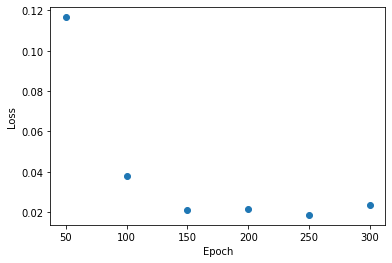

In [ ]:
x, y = [],[]

for i in range(50,350,50):
    print(i)
    model = dc.models.MultitaskClassifier(n_tasks, n_features)
    loss = model.fit(train_dataset, nb_epoch=i)
    x.append(i)
    y.append(loss)

plt.scatter(x,y)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

posMinLoss = y.index(min(y)) #Position of minimum loss in list y
minEpoch = x[posMinLoss] #nb_epoch corresponding to the smallest loss

In [ ]:
model = dc.models.MultitaskClassifier(n_tasks, n_features)
model.fit(train_dataset, nb_epoch=minEpoch)

0.021732995510101317

###Continuing...

In [ ]:
test_dataset = dc.data.Dataset.from_dataframe(dfdropOutClintox_Tox21) #Test dataset is clintox without the "n" removed molecules previously as it doesn't have ROMol structure

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score, np.mean)
print("Train scores")
print(model.evaluate(train_dataset, [metric], transformers))
print("Validation scores")
print(model.evaluate(valid_dataset, [metric], transformers))
print("Test scores")
print(model.evaluate(test_dataset, [metric], transformers))

Train scores
{'mean-roc_auc_score': 0.9957134390358853}
Validation scores
{'mean-roc_auc_score': 0.7187479757054489}
Test scores
{'mean-roc_auc_score': 0.7502083001957488}


##Explaining model (LIME)

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 2.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f6a3fca93f136fa64cc6e483fbb2e4852cbc3a1add617bb00e19b235a7887960
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
from lime import lime_tabular
feature_names = ["fp_%s"  % x for x in range(1024)]
explainer = lime_tabular.LimeTabularExplainer(train_dataset.X, 
                                              feature_names=feature_names, 
                                              categorical_features=feature_names,
                                              class_names=['not toxic', 'toxic'], 
                                              discretize_continuous=True)

In [ ]:
# We need a function which takes a 2d numpy array (samples, features) and returns predictions (samples,)

def eval_model(my_model,i):
    def eval_closure(x):
        ds = dc.data.NumpyDataset(x, n_tasks=12)
        # The 0th task is NR-AR
        predictions = my_model.predict(ds)[:,i]
        return predictions
    return eval_closure

##################################
def fp_mol(mol, fp_length=1024):
    """
    returns: dict of <int:list of string>
        dictionary mapping fingerprint index
        to list of SMILES strings that activated that fingerprint
    """
    d = {}
    feat = dc.feat.CircularFingerprint(sparse=True, smiles=True, size=1024)
    retval = feat._featurize(mol)
    for k, v in retval.items():
        index = k % fp_length
        if index not in d:
            d[index] = set()
        d[index].add(v['smiles'])
    return d
#######################
def verifTox(l):
  somaTox = 0.0
  somaNao = 0.0

  for peso in l:
      if peso > 0:
        somaTox += peso
      else:
        somaNao += peso
  if abs(somaTox) > abs(somaNao):
    return ("YES",somaTox,somaNao)
  else:
    return ("NO",somaTox,somaNao)
#########################

In [ ]:
import statistics as st

dfAllFragMolPeso = pd.DataFrame()
dfAllMolTasksInfo = pd.DataFrame()
dfAllMolTox = pd.DataFrame()

for i in range(12):
    model_fn = eval_model(model,i)
    lista_active_id = np.where((test_dataset.y[:,i] == 1) * (model.predict(test_dataset)[:,0,1] > 0.8))[0] #list of molecules which are toxic and (*) are predicted as such by the model
    print('\nTASK:',i)
    print()

    #Dataframe that indicates if the molecule is toxic or not and how much is it(total)
    dfMolTox = pd.DataFrame(columns=["Task","Molecule Index","Molecule Id","Result","Toxicity","Non-Toxicity"])
    
    for active_id in lista_active_id:
      exp = explainer.explain_instance(test_dataset.X[active_id], model_fn, num_features=1024, top_labels=1)
    
      # What fragments activated what fingerprints in our active molecule?
      my_fragments = fp_mol(Chem.MolFromSmiles(test_dataset.ids[active_id]))
      q = [key for key in exp.as_map().keys()][0]
      map = exp.as_map()[q]
      dic = dict(map)
      lista_pesos = []
      
      #Dataframe with molecule's information, its toxic fragments and weight
      dfFragMolPeso = pd.DataFrame(columns=["Task","Fingerprint","Fragment SMILES","Weight","Active Molecule"])
      
      for fp_index in my_fragments:
        if fp_index in dic: 
          peso = dic[fp_index]
          frag = my_fragments[fp_index]
          lista_pesos.append(peso)

          if peso > 0: #Weight that positively contributes to toxicity
              dfFragMolPeso.loc[dfFragMolPeso.shape[0]] = [i,fp_index,frag, peso,active_id]#Adding a row at the bottom
      
      #Inserting data at dfMolTox
      vt = verifTox(lista_pesos) #variable that contains the sum of all of toxic fragments weight, non toxic fragment weight and the result of the molecule (if it's more toxic or not)
      smile = test_dataset.select([active_id]).ids[0] #smile of the molecule in question
      dfMolTox.loc[dfMolTox.shape[0]] = [i,active_id,smile,vt[0],vt[1],vt[2]]
      dfAllMolTox = dfAllMolTox.append(dfMolTox)
      
      #Putting together all dfFragMolPeso
      if len(lista_pesos) != 0:
          #Selecting a minimum toxicity contribution (a minimum weight) to assess which fragments could be discarded. Setting a tolerance
          tol = st.mean(lista_pesos) #weight's mean
          dfFragMolPeso.drop(dfFragMolPeso.loc[dfFragMolPeso['Weight']<tol].index,inplace=True) #dropping indexes which have less weight than the tol tolerance
      

          #Unsetting set object of column Fragment Smiles in dfFragMolPeso
          for (j,set_smiles) in enumerate(dfFragMolPeso['Fragment SMILES']): #el = set_smiles

              if  set_smiles == None or len(set_smiles) == 0:
                  dfFragMolPeso['Fragment SMILES'].iloc[j] = np.nan

              elif len(set_smiles) > 1: #If fp is activated by more than one fragment
                  k = j
                  for smi in set_smiles:
                    if smi != '': #Passing by possible bug (Empty smile)
                      if k == j: #Represents the first smile of the set of smiles
                          dfFragMolPeso['Fragment SMILES'].iloc[k] = smi
                          k = dfFragMolPeso.shape[0] #From now on k will be always the index of the new adding row
                      else:
                          dfFragMolPeso.loc[k] = dfFragMolPeso.iloc[j] #copying data of original row (all the information, exept smile)
                          dfFragMolPeso['Fragment SMILES'].loc[k] = smi #modifying the fragment smile (which is still in set) to the smile alone (isolated) in the new position k
              else:
                  dfFragMolPeso['Fragment SMILES'].iloc[j] = list(set_smiles)[0]

          #Dropping possible bugs (empty smile)
          dfFragMolPeso.dropna(inplace=True)
          dfFragMolPeso.drop(dfFragMolPeso.loc[dfFragMolPeso['Fragment SMILES'].isin([''])].index,inplace=True)

          dfAllFragMolPeso = dfAllFragMolPeso.append(dfFragMolPeso)
    
    
    #Exporting data of the molecule's toxicity classification (dfMolTox)
    dfMolTox.to_excel('TASK'+str(i)+'-Classificacao das Moleculas.xlsx') 
    files.download('TASK'+str(i)+'-Classificacao das Moleculas.xlsx')




TASK: 0



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 1



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 2



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 3



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 4



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 5



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 6



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 7



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 8



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 9



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 10



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


TASK: 11



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Setting task as index
dfAllFragMolPeso.set_index('Task',inplace=True)

In [ ]:
#Grouping dfAllFragMolPeso by its tasks
ag = dfAllFragMolPeso.groupby(level=0)

In [ ]:
#Function to count how much a smile appears in a task
def contaSmile (grupoFrag):
    dic ={}
    for smile in grupoFrag['Fragment SMILES']:
      qtdSmile = dic.get(smile,0)
      qtdSmile += 1
      dic[smile] = qtdSmile
    return dic

#Funciton to sum the weights of each smile of the task
def somaPesos (grupoFrag):
  dic = {}
  for smile in grupoFrag['Fragment SMILES']:
    soma = dic.get(smile,0)
    if soma == 0:
        pesosSmile = grupoFrag['Weight'].loc[grupoFrag['Fragment SMILES'] == smile]
        soma = sum(pesosSmile)
        dic[smile] = soma
  return dic


In [ ]:
def pegaMolecula(grupoFrag):
  return list(grupoFrag['Active Molecule'])

In [ ]:
"""
The next command counts how much a fragment repeats in a task
"""
srTaskSmiQtd = ag.apply(contaSmile)
srTaskSmiWeightTotal = ag.apply(somaPesos)
dfAllTasksInfo = pd.DataFrame()

dftop5Tasks = pd.DataFrame()

for i,task in enumerate(srTaskSmiQtd.index):
  dicTask = srTaskSmiQtd.values[i]
  dicTaskWeight = srTaskSmiWeightTotal.values[i]

  d = pd.DataFrame(dicTask.values(),index=dicTask.keys())
  d.rename_axis('Fragment SMILES',inplace=True)
  d.rename(columns={0:'Quantity'},inplace=True)
  d['Task'] = task
  d.reset_index(inplace=True)
  PandasTools.AddMoleculeColumnToFrame(d,smilesCol='Fragment SMILES')
  d.set_index('Fragment SMILES',inplace=True)

  #Adding Total Weight of each smile
  d['Total Weight'] = dicTaskWeight.values()
  
  #Grouping Smile and adding a new column with all the active molecules for each specific fragment smile
  agFragTot = dfAllFragMolPeso.loc[dfAllFragMolPeso.index==task].groupby(by='Fragment SMILES')
  srMolecules = agFragTot.apply(pegaMolecula)
  d['Active Molecules'] = srMolecules
  
  #Setting multindex
  d.reset_index(inplace=True)
  d.set_index(['Task','Fragment SMILES'],inplace=True)
  d.sort_values(by='Total Weight',ascending=False,inplace=True)
  
  #Deleting the compounds that does not have ROMol Structures
  d.dropna(inplace=True)

  dftop5Tasks = dftop5Tasks.append(d.head())
  dfAllTasksInfo = dfAllTasksInfo.append(d)



##Highlights of top5

In [ ]:
#Highlight of the top5 of each task

lHighlights = []
for ((task,frag),lmolecules) in dftop5Tasks['Active Molecules'].iteritems():
  index_mol = lmolecules[0]
  molecule_smile = str(test_dataset.select(index_mol).ids)
  m = Chem.MolFromSmiles(molecule_smile)
  substructure = Chem.MolFromSmiles(frag)
  m.GetSubstructMatches(substructure)
  lHighlights.append(m)

In [ ]:
dftop5Tasks['Highlight First Active Molecule'] = lHighlights

In [ ]:
test_dataset.to_dataframe()['ids'].to_excel('test_dataset_molecules.xlsx')
files.download('test_dataset_molecules.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Exporting Data

In [ ]:
!pip install xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 149 kB 2.1 MB/s 


In [ ]:
from google.colab import files

#Exporting dfAllTasksInfo without figures
dfAllTasksInfo.to_excel('Contribuição SMILES em Tasks.xlsx') 
files.download('Contribuição SMILES em Tasks.xlsx')

#Exporting dfAllTasksInfo with figures
dfAllTasksInfo.reset_index(inplace=True)
PandasTools.SaveXlsxFromFrame(dfAllTasksInfo,'Contribuição SMILES em Tasks_COM FIGURA.xlsx', molCol='ROMol',size=(100,100))
files.download('Contribuição SMILES em Tasks_COM FIGURA.xlsx')

#Exporting dfAllFragMolPeso
dfAllFragMolPeso.to_excel('Descrição Fingerprint,SMILES e Moleculas.xlsx')
files.download('Descrição Fingerprint,SMILES e Moleculas.xlsx')

#Exporting dftop5Tasks
dftop5Tasks.to_excel('Highlights Top 5.xlsx')
files.download('Highlights Top 5.xlsx')

#Exporting dfAllTasksInfo with figures
dftop5Tasks.reset_index(inplace=True)
PandasTools.SaveXlsxFromFrame(dftop5Tasks,'Highlights Top 5_COM FIGURA.xlsx', molCol='Highlight First Active Molecule',size=(150,150))
files.download('Highlights Top 5_COM FIGURA.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Quantity  \
Task Fragment SMILES             
0    CC(C)=O                66   
     CCC[C@H](C)C           37   
     CCC                   156   
     CC(C)(C)C              84   
     C=CC                   76   

                                                                  ROMol  \
Task Fragment SMILES                                                      
0    CC(C)=O          <img data-content="rdkit/molecule" src="data:i...   
     CCC[C@H](C)C     <img data-content="rdkit/molecule" src="data:i...   
     CCC              <img data-content="rdkit/molecule" src="data:i...   
     CC(C)(C)C        <img data-content="rdkit/molecule" src="data:i...   
     C=CC             <img data-content="rdkit/molecule" src="data:i...   

                      Total Weight  \
Task Fragment SMILES                 
0    CC(C)=O              4.580683   
     CCC[C@H](C)C         3.973137   
     CCC                  3.385495   
     CC(C)(C)C            3.232757   
     C=CC                 2.490958   

                                                       Active Molecules  \
Task Fragment SMILES                                                      
0    CC(C)=O          [162, 164, 165, 166, 167, 168, 169, 170, 180, ...   
     CCC[C@H](C)C     [185, 186, 188, 199, 200, 201, 202, 203, 204, ...   
     CCC              [162, 162, 163, 164, 165, 165, 166, 166, 166, ...   
     CC(C)(C)C        [162, 162, 163, 163, 164, 165, 166, 167, 167, ...   
     C=CC             [162, 162, 162, 163, 163, 164, 164, 165, 166, ...   

                                        Highlight First Active Molecule  
Task Fragment SMILES                                                     
0    CC(C)=O          <img data-content="rdkit/molecule" src="data:i...  
     CCC[C@H](C)C     <img data-content="rdkit/molecule" src="data:i...  
     CCC              <img data-content="rdkit/molecule" src="data:i...  
     CC(C)(C)C        <img data-content="rdkit/molecule" src="data:i...  
     C=CC             <img data-content="rdkit/molecule" src="data:i...
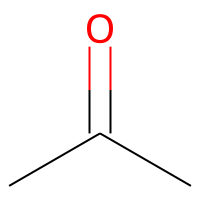
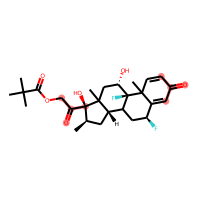
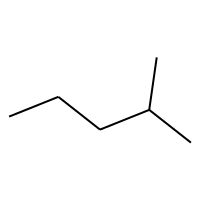
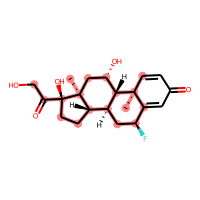
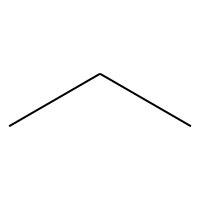
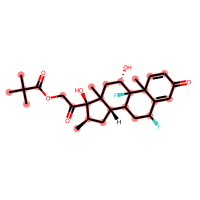
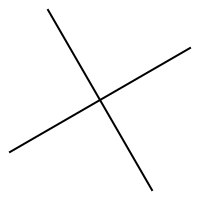
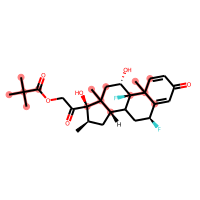
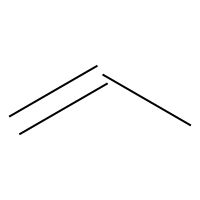
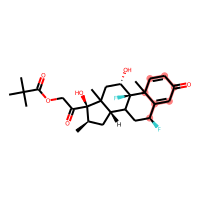

In [ ]:
dftop5Tasks.set_index(['Task','Fragment SMILES']).head(5)

,Task,Fragment SMILES,Quantity,ROMol,Total Weight,Active Molecules,Highlight First Active Molecule,Heavy Atom Count
0,0,CC(C)=O,66,,4.580683,"[162, 164, 165, 166, 167, 168, 169, 170, 180, ...",,4
1,0,CCC[C@H](C)C,37,,3.973137,"[185, 186, 188, 199, 200, 201, 202, 203, 204, ...",,6
2,0,CCC,156,,3.385495,"[162, 162, 163, 164, 165, 165, 166, 166, 166, ...",,3
3,0,CC(C)(C)C,84,,3.232757,"[162, 162, 163, 163, 164, 165, 166, 167, 167, ...",,5
4,0,C=CC,76,,2.490958,"[162, 162, 162, 163, 163, 164, 164, 165, 166, ...",,3

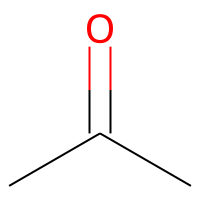
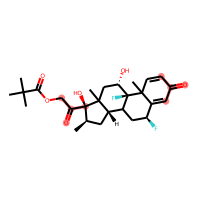
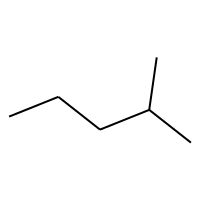
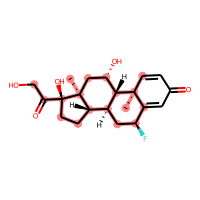
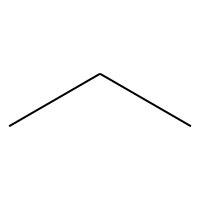
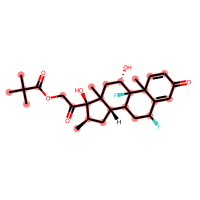
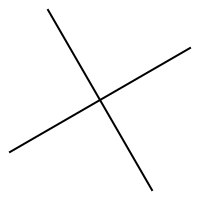
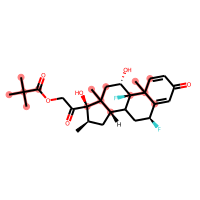
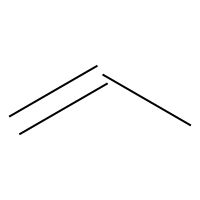
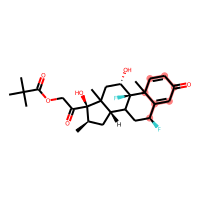

In [ ]:
from rdkit.Chem.Descriptors import HeavyAtomCount

dftop5Tasks['Heavy Atom Count'] = [HeavyAtomCount(Chem.MolFromSmiles(smiles)) for smiles in dftop5Tasks['Fragment SMILES']]
dftop5Tasks.head()

,Task,Fragment SMILES,Quantity,ROMol,Total Weight,Active Molecules,Highlight First Active Molecule,Heavy Atom Count
10,2,C[C@H](O)[C@@](F)([C@H](C)C)C(C)(C)C,2,,0.220561,"[167, 431]",,12
17,3,CC[C@@H]([C@H](C)C)C(C)(C)C,3,,0.111970,"[190, 207, 410]",,10
19,3,CC(C)(C)OC(C)=O,1,,0.082990,[330],,8
15,3,CCCC(C)(C)C,2,,0.183125,"[190, 330]",,7
44,9,C[C@@](C)(O)C(C)=O,1,,0.062470,[470],,7

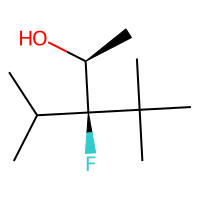
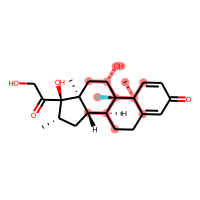
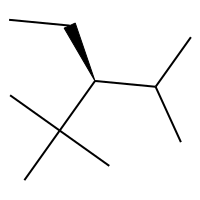
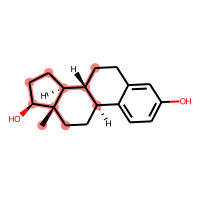
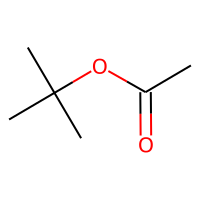
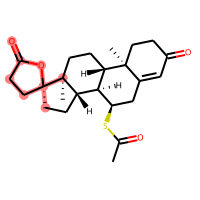
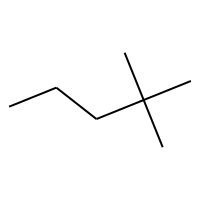
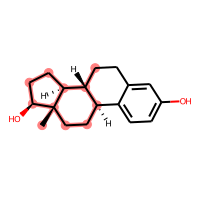
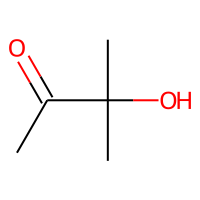
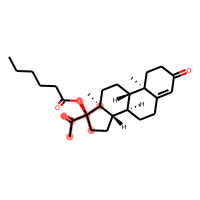

In [ ]:
dftop5Tasks = dftop5Tasks.sort_values(by=['Heavy Atom Count'],ascending=False)
dftop5Tasks.head()

In [ ]:
dftop5Tasks.shape

(55, 8)

,Task,Fragment SMILES,Quantity,ROMol,Total Weight,Active Molecules,Highlight First Active Molecule,Heavy Atom Count
10,2,C[C@H](O)[C@@](F)([C@H](C)C)C(C)(C)C,2,,0.220561,"[167, 431]",,12
17,3,CC[C@@H]([C@H](C)C)C(C)(C)C,3,,0.111970,"[190, 207, 410]",,10
19,3,CC(C)(C)OC(C)=O,1,,0.082990,[330],,8
15,3,CCCC(C)(C)C,2,,0.183125,"[190, 330]",,7
44,9,C[C@@](C)(O)C(C)=O,1,,0.062470,[470],,7

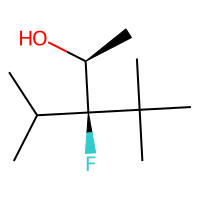
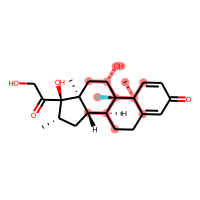
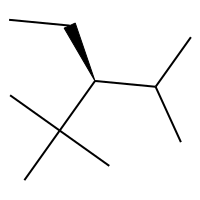
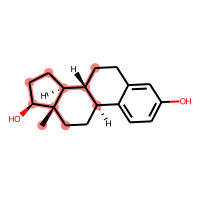
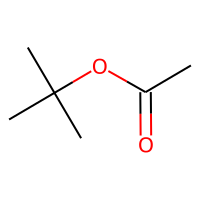
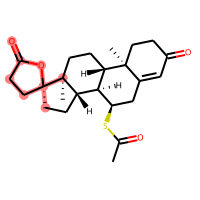
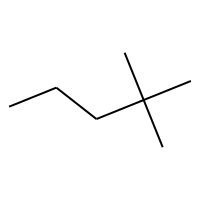
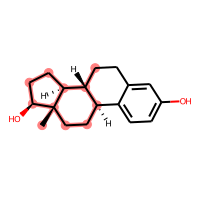
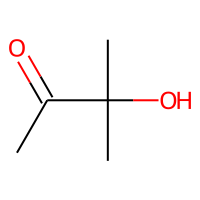
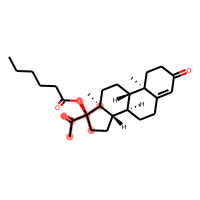

In [ ]:
dftop5Tasks = dftop5Tasks.loc[(dftop5Tasks['Heavy Atom Count']) >= 7]
dftop5Tasks

In [ ]:
dftop5Tasks.shape

(5, 8)

,Task,Fragment SMILES,Quantity,ROMol,Total Weight,Active Molecules,Highlight First Active Molecule,Heavy Atom Count
10,2,C[C@H](O)[C@@](F)([C@H](C)C)C(C)(C)C,2,,0.220561,"[167, 431]",,12
17,3,CC[C@@H]([C@H](C)C)C(C)(C)C,3,,0.111970,"[190, 207, 410]",,10
19,3,CC(C)(C)OC(C)=O,1,,0.082990,[330],,8
15,3,CCCC(C)(C)C,2,,0.183125,"[190, 330]",,7
44,9,C[C@@](C)(O)C(C)=O,1,,0.062470,[470],,7

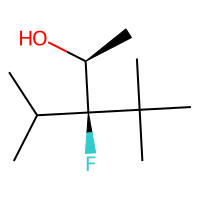
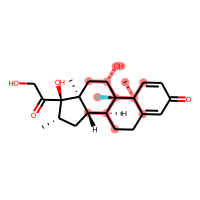
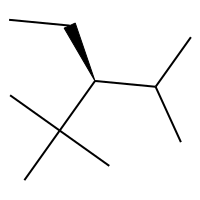
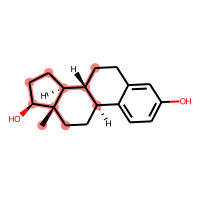
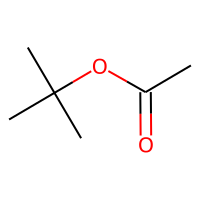
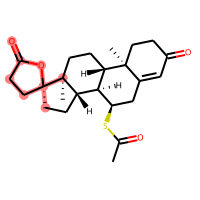
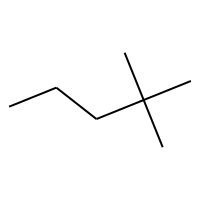
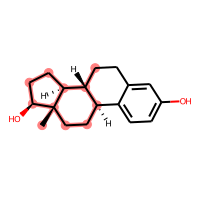
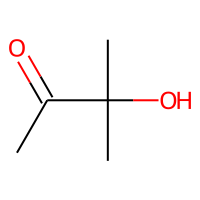
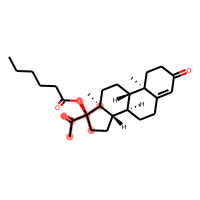

In [ ]:
dftop5Tasks.head()

,Task,Fragment SMILES,Quantity,ROMol,Total Weight,Active Molecules,Highlight First Active Molecule,Heavy Atom Count
10,2,C[C@H](O)[C@@](F)([C@H](C)C)C(C)(C)C,2,,0.220561,"[167, 431]",,12
17,3,CC[C@@H]([C@H](C)C)C(C)(C)C,3,,0.111970,"[190, 207, 410]",,10
19,3,CC(C)(C)OC(C)=O,1,,0.082990,[330],,8
15,3,CCCC(C)(C)C,2,,0.183125,"[190, 330]",,7
44,9,C[C@@](C)(O)C(C)=O,1,,0.062470,[470],,7

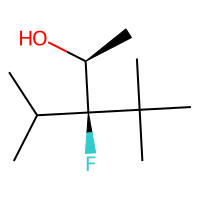
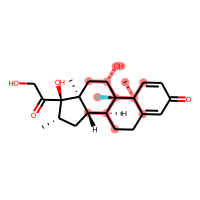
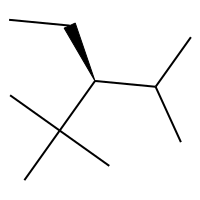
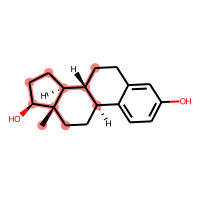
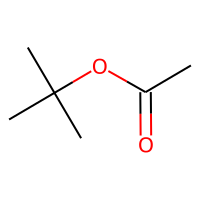
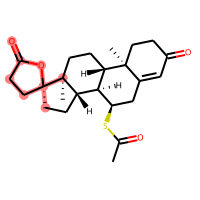
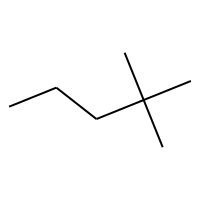
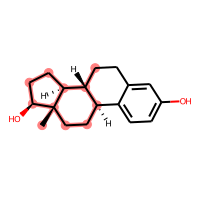
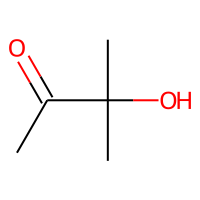
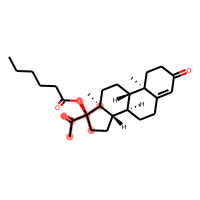

In [ ]:
dftop5Tasks = dftop5Tasks.sort_values(by=['Task'],ascending=True)
dftop5Tasks

,Task,ROMol,Highlight First Active Molecule
10,2,,
17,3,,
19,3,,
15,3,,
44,9,,

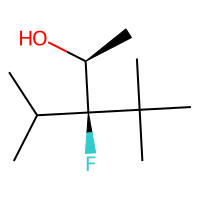
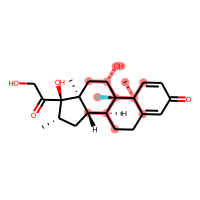
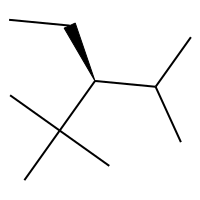
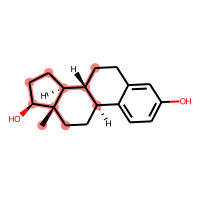
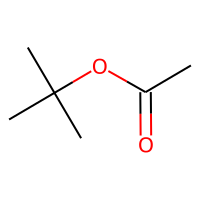
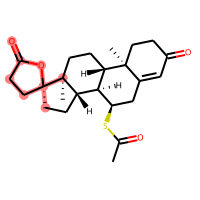
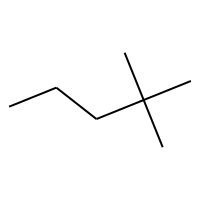
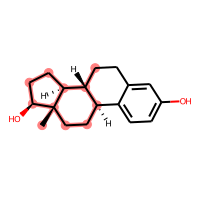
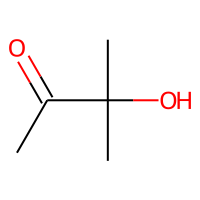
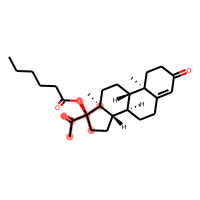

In [ ]:
dftop5Tasks = dftop5Tasks.drop(columns = ['Fragment SMILES', 'Quantity', 'Total Weight', 'Active Molecules', 'Heavy Atom Count'])
dftop5Tasks.head()

In [ ]:
!pip install dataframe-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 2.1 MB/s 


In [ ]:
!apt install chromium-chromedriver

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 12 not upgraded.
Need to get 91.7 MB of archives.
After this operation, 309 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 105.0.5195.102-0ubuntu0.18.04.1 [1,156 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-browser amd64 105.0.5195.102-0ubuntu0.

In [ ]:
import dataframe_image as dfi

dfi.export(dftop5Tasks, 'clintox_1.png')

In [ ]:
from google.colab import files
files.download('clintox_1.png') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>